# Using flax for MNIST Handwritten Digit Classification

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FlorianMarquardt/machine-learning-for-physicists/blob/master/2024/04_tutorial_MNIST.ipynb)

Tutorial code for the lecture series "Machine Learning for Physicists" by Florian Marquardt

See https://machine-learning-for-physicists.org and the current course website linked there!

This notebook shows how to build a dense neural network  and convolutional neural network (CNN) using flax to do the classification task with MNIST handwritten digit dataset.

First version by Remmy Zen 2024. MIT License.

In [ ]:
import jax.numpy as jnp
from jax import grad, value_and_grad, jit, vmap
import jax
import tensorflow as tf
import numpy as np
from flax import linen as nn # the neural-network library from flax
import optax # for optimization
from matplotlib import pyplot as plt # plotting
%config InlineBackend.figure_format='retina'

## Loading the MNIST dataset

In [ ]:
## Load mnist dataset using tensorflow
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

## Normalize input to be between 0 and 1
x_train = x_train / 255.
x_test = x_test / 255.

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

In [ ]:
## Visualize some of the data
num_images = 10

## Choose random index of the data
random_index = np.random.choice(range(60000), size=(num_images,), replace=False) ## replace = false for unique data

plt.figure(figsize=(num_images, 1))
for i, index in enumerate(random_index):
    plt.subplot(1, num_images, i+1)
    plt.imshow(x_train[index], cmap='gray')
    plt.title(y_train[index])
    plt.axis('off')
plt.show()

## MNIST Classification with dense neural network

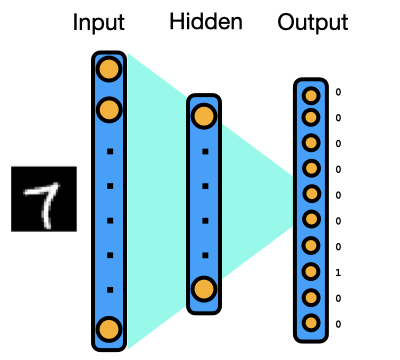


In [ ]:
# define a simple dense neural network  using flax
class DenseNetwork(nn.Module):
  hidden_neurons: int # a parameter we can choose during initialization
  output_neurons: int

  ########################
  ## EXERCISE 1:
  ## What do we need to change to the __call__ function for classification task?
  ########################
  @nn.compact
  def __call__(self,x):
    # note: number of input neurons will be defined
    # by the shape of x when calling the network for the first time!
    x = nn.Dense(features=self.hidden_neurons)(x) # neurons for  hidden layer
    x = nn.relu(x) # relu activation
    x = nn.Dense(features=self.output_neurons)(x) # neurons for output
    x = nn.sigmoid(x) # sigmoid activation
    return x


In [ ]:
# actually produce the network, with randomly initialized parameters

network = DenseNetwork(hidden_neurons=30, output_neurons=10) # get an instance of the "Network" class
x = jnp.zeros((28*28,)) # dummy input for initialization
random_key = jax.random.key(42) # get a random key
params = network.init(random_key, x) # randomly initialize parameters

# call to network.apply, which applies the network
# to x, given the parameters params:
network.apply(params, x)

In [ ]:
# Have a look at the way the parameters are stored:
# inside a dictionary! 'kernel' means the weight matrix!
params

In [ ]:
## Size of the hidden layer
params['params']['Dense_0']['kernel'].shape, params['params']['Dense_1']['kernel'].shape

### Compiling and batch processing

In [ ]:
########################
## EXERCISE 2:
## Implement the categorical cross entropy loss function
## loss = - \sum y_target * \log y_out
########################
# define a cost function, for classification: categorical cross entropy
def cost(params,x,y_target):
  ### NOTE: Remember that this is a batched function
  ### so x size is [batch_size, 784] and y_target size is [batch_size, 1]
  ### 1. Get y_out by applying network and params

  ### 2. Get the one hot labels of the y_target
  one_hot_labels = jax.nn.one_hot(y_target, num_classes=10)

  ### 3. Calculate \sum y_target * \log y_out
  ### (take note of the axis when summing because of the batches)

  ### 4. Take the mean of the loss across the batches
  return 0.

In [ ]:
# batches: vmap does the trick!
batched_cost=vmap(cost,in_axes=(None,0,0))

In [ ]:
# want to average the cost over the batch:
def average_cost(params,x,y_target):
  return jnp.average(batched_cost(params,x,y_target))

In [ ]:
# compiled version of gradient of cost function, which
# returns both the value and the gradient:
batched_value_and_grad_cost=jit(value_and_grad(average_cost))

### Training using optax

#### Preparation of the optax 'optimizer'

In [ ]:
# choose and prepare the optimizer
learning_rate=0.001
optimizer=optax.adam(learning_rate) # choose type of optimizer
opt_state=optimizer.init(params) # initialize the state of the optimizer

#### Running the training loop

In [ ]:
# now you can run a training loop:
num_batches=1000
batch_size=32
cost_history=[]

for train_step in range(num_batches):
  # producing the random batch
  # first, a new random key:
  random_key,new_key=jax.random.split(random_key)
  # produce a new batch (inputs x, desired outputs y):
  random_index = jax.random.choice(new_key, jnp.array(range(x_train.shape[0])), shape=(batch_size,), replace = False) ## replace = false for unique data

  x = jnp.array(x_train[random_index].reshape((batch_size, -1)))
  y = jnp.array(y_train[random_index])

  # get gradients and the current value of the cost function
  cost,grads = batched_value_and_grad_cost(params,x,y)

  # the optax part: calculate the updates and apply them to change 'params':
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  cost_history.append(cost)

In [ ]:
plt.plot(cost_history)
plt.title("Cost vs number of training batches")
plt.show()

### Evaluation

In [ ]:
## Get the accuracy with the test data
x = x_test.reshape((x_test.shape[0], -1))
result = jnp.argmax(network.apply(params,x), axis=-1)

print('Testing accuracy:', jnp.mean(result == y_test))

In [ ]:
## Visualize some of the data
num_images = 10

random_key,new_key=jax.random.split(random_key)
# produce a new batch (inputs x, desired outputs y):
random_index = jax.random.choice(new_key,jnp.array(range(x_test.shape[0])), shape=(num_images,), replace = False) ## replace = false for unique data
plt.figure(figsize=(num_images, 1))
for i, index in enumerate(random_index):
    plt.subplot(1, num_images, i+1)
    plt.imshow(x_test[index], cmap='gray')
    plt.title('Pred: %d\nLabel: %d' % (result[index], y_test[index]))
    plt.axis('off')
plt.show()

In [ ]:
########################
## EXERCISE 3:
## Try to play around with the parameters and see how it affect the training progress
## Try to change the number of hidden neurons, add more hidden layer, learning rate, batch_size, etc.
## Try to get a higher accuracy.
########################

## MNIST Classification with convolutional neural network

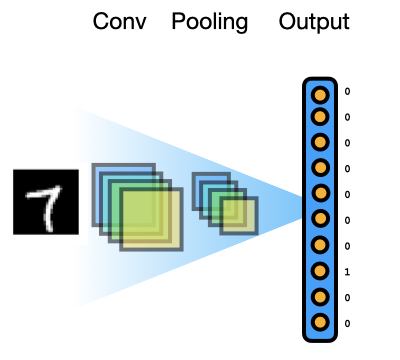

In [ ]:
# define a simple conv neural network using flax
class ConvNetwork(nn.Module):
  conv_features: int
  output_neurons: int

  @nn.compact
  def __call__(self, x):
      x = nn.Conv(features=self.conv_features, kernel_size=(3, 3))(x)  # Convolutional layer
      x = nn.relu(x)
      x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))  # Pooling layer
      x = x.reshape((x.shape[0], -1))  # Flatten
      x = nn.Dense(features=self.output_neurons)(x)
      x = nn.softmax(x)  # Use log softmax for better numerical stability
      return x

In [ ]:
# actually produce the network, with randomly initialized parameters
network = ConvNetwork(conv_features=20, output_neurons=10) # get an instance of the "Network" class
x = jnp.zeros((1,28,28,1)) # dummy input for initialization
random_key = jax.random.key(42) # get a random key
params = network.init(random_key, x) # randomly initialize parameters

# call to network.apply, which applies the network
# to x, given the parameters params:
network.apply(params, x)

In [ ]:
# Have a look at the way the parameters are stored:
# inside a dictionary! 'kernel' means the weight matrix!
params

In [ ]:
## Shape of the conv layer (kernel_size, kernel_size, dimension, conv_features)
params['params']['Conv_0']['kernel'].shape

### Compiling and batch processing

Nothing changes here for CNN

In [ ]:
# batches: vmap does the trick!
batched_cost=vmap(cost,in_axes=(None,0,0))

In [ ]:
# compiled version of gradient of cost function, which
# returns both the value and the gradient:
batched_value_and_grad_cost=jit(value_and_grad(average_cost))

### Training using optax

#### Preparation of the optax 'optimizer'

In [ ]:
# choose and prepare the optimizer
learning_rate=0.001
optimizer=optax.adam(learning_rate) # choose type of optimizer
opt_state=optimizer.init(params) # initialize the state of the optimizer

#### Running the training loop

In [ ]:
# now you can run a training loop:
num_batches=1000
batch_size=32
cost_history=[]

for train_step in range(num_batches):
  # producing the random batch
  # first, a new random key:
  random_key,new_key=jax.random.split(random_key)
  # produce a new batch (inputs x, desired outputs y):
  random_index = jax.random.choice(new_key, jnp.array(range(x_train.shape[0])), shape=(batch_size,), replace = False) ## replace = false for unique data

  x = jnp.array(x_train[random_index].reshape((batch_size, 1, 28, 28, 1)))
  y = jnp.array(y_train[random_index])

  # get gradients and the current value of the cost function
  cost,grads = batched_value_and_grad_cost(params,x,y)

  # the optax part: calculate the updates and apply them to change 'params':
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  cost_history.append(cost)

In [ ]:
plt.plot(cost_history)
plt.title("Cost vs number of training batches")
plt.show()

### Evaluation

In [ ]:
## Get the accuracy with the test data
x = x_test.reshape((x_test.shape[0], 28, 28, 1))
result = jnp.argmax(network.apply(params,x), axis=-1)

print('Testing accuracy:', jnp.mean(result == y_test))

In [ ]:
## Visualize some of the data
num_images = 10

random_key,new_key=jax.random.split(random_key)
# produce a new batch (inputs x, desired outputs y):
random_index = jax.random.choice(new_key,jnp.array(range(x_test.shape[0])), shape=(num_images,), replace = False) ## replace = false for unique data
plt.figure(figsize=(num_images, 1))
for i, index in enumerate(random_index):
    plt.subplot(1, num_images, i+1)
    plt.imshow(x_test[index], cmap='gray')
    plt.title('Pred: %d\nLabel: %d' % (result[index], y_test[index]))
    plt.axis('off')
plt.show()

In [ ]:
########################
## EXERCISE 4:
## Try to play around with the parameters and see how it affect the training progress
## Try to change the number of conv_features, add more conv and pooling layer, window_size,
## kernel_size, stride, learning rate, batch_size, etc.
## Try to get a higher accuracy.
########################

## Noisy MNIST Classification with convolutional neural network

In [ ]:
## Get the accuracy with a noisy test data
########################
## EXERCISE 5:
## Add a gaussian noise to the data and check how it changes the accuracy.
## Play around with the mean of the Gaussian, does higher noise decrease the classification accuracy?
## Hint: See the np.random.normal function.
########################
gaussian_noise = 0.0 ## TODO: Implement gaussian noise here
x = x_test + gaussian_noise
x = x.reshape((x_test.shape[0], 28, 28, 1))

result = jnp.argmax(network.apply(params,x), axis=-1)

print('Testing accuracy:', jnp.mean(result == y_test))

In [ ]:
## Visualize some of the data
num_images = 10

random_key,new_key=jax.random.split(random_key)
# produce a new batch (inputs x, desired outputs y):
random_index = jax.random.choice(new_key,jnp.array(range(x.shape[0])), shape=(num_images,), replace = False) ## replace = false for unique data
plt.figure(figsize=(num_images, 1))
for i, index in enumerate(random_index):
    plt.subplot(1, num_images, i+1)
    plt.imshow(x[index], cmap='gray')
    plt.title('Pred: %d\nLabel: %d' % (result[index], y_test[index]))
    plt.axis('off')
plt.show()

In [ ]:
## train with noise
batched_cost=vmap(cost,in_axes=(None,0,0))
batched_value_and_grad_cost=jit(value_and_grad(average_cost))

network_noisy = ConvNetwork(conv_features=20, output_neurons=10) # get an instance of the "Network" class
x = jnp.zeros((1,28,28,1)) # dummy input for initialization
random_key = jax.random.key(42) # get a random key
params_noisy = network_noisy.init(random_key, x) # randomly initialize parameters

num_batches=1000
batch_size=32
cost_history=[]

for train_step in range(num_batches):
  # producing the random batch
  # first, a new random key:
  random_key,new_key=jax.random.split(random_key)
  # produce a new batch (inputs x, desired outputs y):
  random_index = jax.random.choice(new_key, jnp.array(range(x_train.shape[0])), shape=(batch_size,), replace = False) ## replace = false for unique data

  ########################
  ## EXERCISE 6:
  ## Let us train neural network with noisy data as well.
  ## Add a random Gaussian noise to the training data during training.
  ## Hint: See the np.random.normal function.
  ########################
  gaussian_noise = 0.0 ## TODO: Implement gaussian noise here
  x = x_train[random_index] + gaussian_noise
  x = jnp.array(x.reshape((batch_size, 1, 28, 28, 1)))
  y = jnp.array(y_train[random_index])

  # get gradients and the current value of the cost function
  cost,grads = batched_value_and_grad_cost(params_noisy,x,y)

  # the optax part: calculate the updates and apply them to change 'params':
  updates, opt_state = optimizer.update(grads, opt_state)
  params_noisy = optax.apply_updates(params_noisy, updates)

  cost_history.append(cost)

In [ ]:
plt.plot(cost_history)
plt.title("Cost vs number of training batches")
plt.show()

In [ ]:
## Get the accuracy with a noisy test data
########################
## EXERCISE 7:
## Does training with noisy data helps to improve the accuracy?
########################
gaussian_noise = 0.0 ## TODO: Implement gaussian noise here
x = x_test + gaussian_noise
x = x.reshape((x_test.shape[0], 28, 28, 1))

result = jnp.argmax(network_noisy.apply(params_noisy,x), axis=-1)

print('Testing accuracy:', jnp.mean(result == y_test))

In [ ]:
## Visualize some of the data
num_images = 10

random_key,new_key=jax.random.split(random_key)
# produce a new batch (inputs x, desired outputs y):
random_index = jax.random.choice(new_key,jnp.array(range(x.shape[0])), shape=(num_images,), replace = False) ## replace = false for unique data
plt.figure(figsize=(num_images, 1))
for i, index in enumerate(random_index):
    plt.subplot(1, num_images, i+1)
    plt.imshow(x[index], cmap='gray')
    plt.title('Pred: %d\nLabel: %d' % (result[index], y_test[index]))
    plt.axis('off')
plt.show()

In [ ]:
########################
## TAKE HOME EXERCISE:
## 1. Instead of noise, what if you randomly occlude the image?
## 2. In the current training, we do not use any validation data. A good practice
##    in training a neural network is to use Early Stopping that stops the training
##    when validation loss stop decreasing. Try to implement this.
########################